In [3]:
!pip install --quiet ipyleaflet rdflib requests
!pip install pydotplus

In [12]:
!pip install  pydot

# Exploring cross-dataset relationships using Loc-I

This notebook demonstrates how you use Loc-I to traverse across from one geographic dataset to another via `Loc-I Linksets`.
We show how to achieve this using the Loc-I Integration API (https://api.loci.cat).

In [4]:
import urllib, json, requests

Query for the meshblock with ID string `50055290000` and get the feature URI 

In [5]:
# get a meshblock
meshblock_id = 50055290000

#assume we don't know the URI so let's do a search 
url = "https://api.loci.cat/api/v1/location/find-by-label?query={}".format(meshblock_id)
r = requests.get(url)
jsondata = r.json()
jsondata

{'took': 2,
 'timed_out': False,
 '_shards': {'total': 5, 'successful': 5, 'skipped': 0, 'failed': 0},
 'hits': {'total': 1,
  'max_score': 22.739025,
  'hits': [{'_index': 'default_index',
    '_type': 'location',
    '_id': 'mEj1PXgBQXmYsT7kOKMG',
    '_score': 22.739025,
    '_source': {'uri': 'http://linked.data.gov.au/dataset/asgs2016/meshblock/50055290000',
     'label': '50055290000'}}]},
 'ok': True}

Get the resulting Feature URI 

In [6]:
#get the first hit
meshblock_uri = jsondata['hits']['hits'][0]['_source']['uri']
meshblock_uri

'http://linked.data.gov.au/dataset/asgs2016/meshblock/50055290000'

Tell me more about this feature via HTTP content negotiation of URI...

In [7]:
#tell me more about the meshblock
# get semantic info about the feature
header={'Accept': 'text/turtle'}
url = meshblock_uri
r = requests.get(url, headers=header)
res_body = r.text
print(res_body)

@prefix asgs: <http://linked.data.gov.au/def/asgs#> .
@prefix asgs-cat: <http://linked.data.gov.au/def/asgs-cat/> .
@prefix asgs-id: <http://linked.data.gov.au/def/asgs/id#> .
@prefix data: <http://linked.data.gov.au/def/datatype/> .
@prefix dcterms: <http://purl.org/dc/terms/> .
@prefix geo: <http://www.opengis.net/ont/geosparql#> .
@prefix geox: <http://linked.data.gov.au/def/geox#> .
@prefix loci: <http://linked.data.gov.au/def/loci#> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix xml: <http://www.w3.org/XML/1998/namespace> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

<http://linked.data.gov.au/dataset/asgs2016/destinationzone/511311450> a asgs:DestinationZone ;
    dcterms:identifier "511311450"^^asgs-id:dznCode2016 ;
    geo:sfContains <http://linked.data.gov.au/dataset/asgs2016/meshblock/50055290000> .

<http://linked.data.gov.au/dataset/asgs2016/localgovernmentarea/51330> a asgs:LocalGovernm

In [8]:
from  rdflib import Graph 
g = Graph()
result = g.parse(data=res_body, format="text/turtle")
g

<Graph identifier=N6a0e29963e364f19949e76dd712babc9 (<class 'rdflib.graph.Graph'>)>

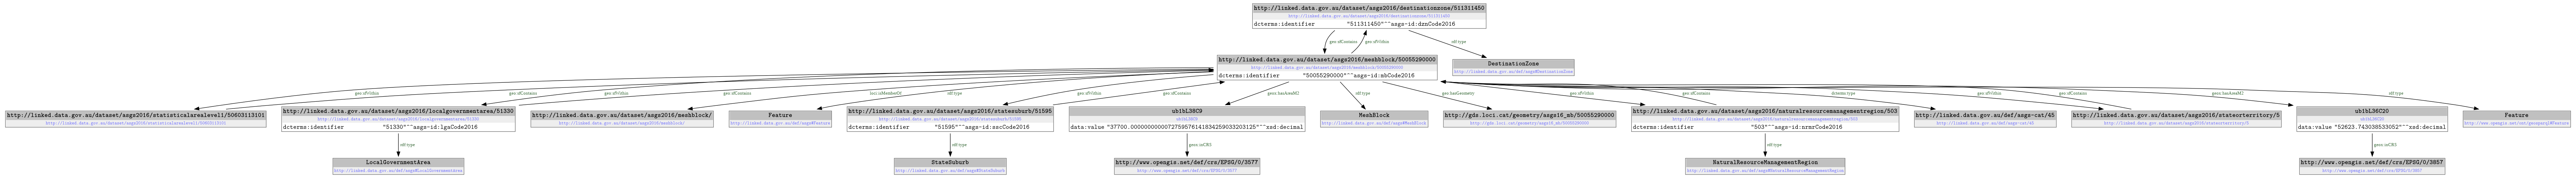

In [32]:
import pydot
import io
from IPython.display import display, Image
from rdflib.tools.rdf2dot import rdf2dot

def visualize(g):
    stream = io.StringIO()
    rdf2dot(g, stream, opts = {display})
    graphs = pydot.graph_from_dot_data(stream.getvalue())
    graph = graphs[0]
    #print(graphs)
    #graph.set_size('"100,100!"')
    png = graph.create_png(prog='dot')
    #graph.write_png('graph.png')
    #svg = graph.create_svg()
    display(Image(png))
    
    
visualize(g)

In [33]:
#you could use rdflib to do some more digging into the semantic description to get the geometry... 
import rdflib
g=rdflib.Graph()
g.load(meshblock_uri)

#for s,p,o in g:
#    print(s, p, o)

geom_uri = None
for row in g.query(
            '''
            PREFIX geo: <http://www.opengis.net/ont/geosparql#>
            select ?g where { ?feature geo:hasGeometry ?g .}
            '''):
        geom_uri = (row.g)
if(geom_uri != None):
    print(geom_uri)

http://gds.loci.cat/geometry/asgs16_mb/50055290000


In [34]:
# get the geojson representation of the geom
header={'Accept': 'application/json'}
r = requests.get(geom_uri, headers=header)
geojson_data = r.json()

params={'_view': 'centroid'}
r = requests.get(geom_uri, headers=header, params=params)
centroid_geojson_data = r.json()



In [35]:
#draw the geometry for the feature on a map
import ipyleaflet as ipy 
import ipywidgets as ipyw
from ipyleaflet import GeoJSON, Map, Marker

x_coord = centroid_geojson_data['coordinates'][1]
y_coord = centroid_geojson_data['coordinates'][0]

map = ipy.Map(center=[x_coord, y_coord], zoom=15)
label = ipyw.Label(layout=ipyw.Layout(width='100%'))

geo_json1 = GeoJSON(data=geojson_data, style = {'color': 'red', 'opacity':1, 'weight':1.9, 'fillOpacity':0.5})
map.add_layer(geo_json1)
map

Map(center=[-32.046211537, 115.876243445], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in…

## Get relationships with other regions, e.g. Geofabric

We can use the Feature URI descriptions to explore relationships with other things.

In [36]:
for row in g.query(
            '''
            PREFIX geo: <http://www.opengis.net/ont/geosparql#>
            select ?relatedFeaturesUp where { 
               ?feature geo:sfWithin ?relatedFeaturesUp .
            }
            '''):
        print(row.relatedFeaturesUp)

http://linked.data.gov.au/dataset/asgs2016/naturalresourcemanagementregion/503
http://linked.data.gov.au/dataset/asgs2016/statisticalarealevel1/50603113101
http://linked.data.gov.au/dataset/asgs2016/statesuburb/51595
http://linked.data.gov.au/dataset/asgs2016/destinationzone/511311450
http://linked.data.gov.au/dataset/asgs2016/stateorterritory/5
http://linked.data.gov.au/dataset/asgs2016/localgovernmentarea/51330


We can use the Feature URI and the Loc-I integration API to explore relationships in other geographic regions, e.g. Geofabric.

In [39]:
#search for things overlapping in other regions

payload = {
    'uri': meshblock_uri, 
    'areas': 'true',
    'proportion': 'true',
    'contains': 'false',
    'within':'true',
    'crosswalk':'true',
    'count': 100,
    'offset': 0
}

url = "https://api.loci.cat/api/v1/location/overlaps"
r = requests.get(url, params=payload)
data = r.json()

In [41]:
import pandas as pd    

df = pd.json_normalize(data['overlaps'])
df

,uri,intersectionArea,featureArea,forwardPercentage,reversePercentage
0,http://linked.data.gov.au/dataset/gnaf-2016-05...,nan,NaN,nan,nan
1,http://linked.data.gov.au/dataset/gnaf-2016-05...,nan,nan,nan,nan
2,http://linked.data.gov.au/dataset/gnaf-2016-05...,nan,nan,nan,nan
3,http://linked.data.gov.au/dataset/gnaf-2016-05...,nan,NaN,nan,nan
4,http://linked.data.gov.au/dataset/gnaf-2016-05...,nan,nan,nan,nan
5,http://linked.data.gov.au/dataset/gnaf-2016-05...,nan,NaN,nan,nan
6,http://linked.data.gov.au/dataset/gnaf-2016-05...,nan,NaN,nan,nan
7,http://linked.data.gov.au/dataset/gnaf-2016-05...,nan,NaN,nan,nan
8,http://linked.data.gov.au/dataset/gnaf-2016-05...,nan,NaN,nan,nan
9,http://linked.data.gov.au/dataset/gnaf-2016-05...,nan,NaN,nan,nan


That's obviously too many results, so let's filter to a particular FeatureType - Geofabric RiverRegion...

In [42]:
feature_type = 'http://linked.data.gov.au/def/geofabric#RiverRegion'

payload = {
    'uri': meshblock_uri, 
    'areas': 'true',
    'proportion': 'true',
    'contains': 'false',
    'within':'true',
    'crosswalk':'true',
    'output_type' : feature_type,
    'count': 100,
    'offset': 0
}

url = "https://api.loci.cat/api/v1/location/overlaps"
r = requests.get(url, params=payload)
jsondata = r.json()
jsondata

{'meta': {'count': 1, 'offset': 0, 'featureArea': '37700.00000000'},
 'overlaps': [{'uri': 'http://linked.data.gov.au/dataset/geofabric/riverregion/9400291',
   'intersectionArea': '37700.0',
   'featureArea': '121447895188.67200000',
   'forwardPercentage': '100',
   'reversePercentage': '3.1042118878579336e-05'}]}

In [43]:
df = pd.json_normalize(jsondata['overlaps'])
df

,uri,intersectionArea,featureArea,forwardPercentage,reversePercentage
0,http://linked.data.gov.au/dataset/geofabric/ri...,37700.0,121447895188.67200000,100,3.1042118878579336e-05


In [44]:
rr_uri = jsondata['overlaps'][0]['uri']
rr_uri

'http://linked.data.gov.au/dataset/geofabric/riverregion/9400291'

In [45]:
# get the geometry for the CC feature and add it to the map
g=rdflib.Graph()
g.load(rr_uri)

#for s,p,o in g:
#    print(s, p, o)

geom_uri = None
for row in g.query(
            '''
            PREFIX geo: <http://www.opengis.net/ont/geosparql#>
            select ?g where {{ <{uri}> geo:hasGeometry ?g .}}
            '''.format(uri=rr_uri)):
        geom_uri = (row.g)
if(geom_uri != None):
    print(geom_uri)
# get the geojson representation of the geom
header={'Accept': 'application/json'}
r = requests.get(geom_uri, headers=header)
geojson_data = r.json()


x_coord = centroid_geojson_data['coordinates'][1]
y_coord = centroid_geojson_data['coordinates'][0]

map2 = ipy.Map(center=[x_coord, y_coord], zoom=12)
label = ipyw.Label(layout=ipyw.Layout(width='100%'))

geo_json2 = GeoJSON(data=geojson_data, style = {'color': 'blue', 'fillcolor': 'blue', 'opacity':1, 'weight':1.9, 'fillOpacity':0.1})
map2.add_layer(geo_json1)
map2.add_layer(geo_json2)
map2

http://gds.loci.cat/geometry/geofabric2_1_1_riverregion/9400291


Map(center=[-32.046211537, 115.876243445], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in…

Ta-da!

You can see that the RiverRegion instance (shown in blue) is much larger than the meshblock (shown in red). 

We hope you enjoyed that little demonstration of how to traverse from a ASGS MeshBlock across to the Geofabric RiverRegion based on linkset relationships registered in Loc-I.